<a href="https://colab.research.google.com/github/kimhyeonzi/TIL/blob/main/SEIR_ripple_effectipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#초기 감염자 100명
## 마스크 미착용자 40%
## 마스크 미착용자 30%
그래프 모양 달라짐
→ 임계점 : 31.1%

KF94 Mask: Peak Infected: 390,496, Peak Day: 481 days


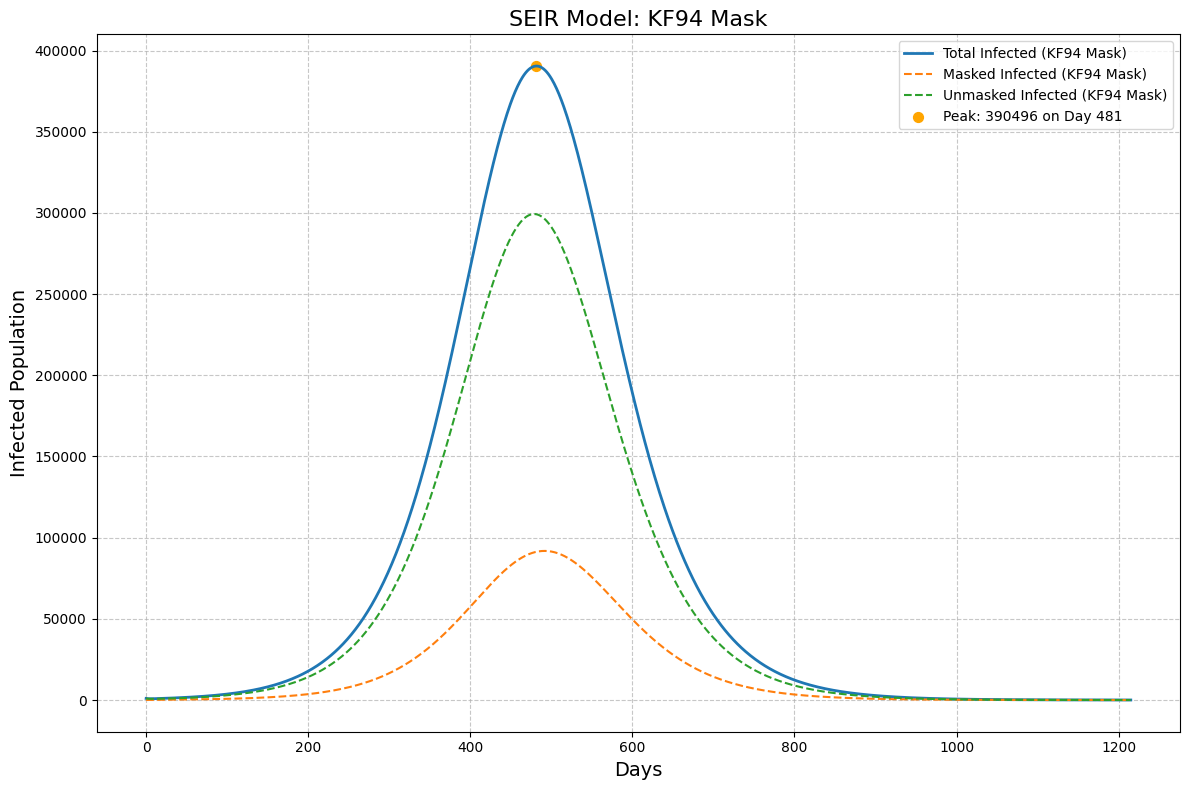

In [ ]:
#마스크 미착용자 40%
#초기감염자 100명
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# SEIR 모델 방정식
def seir_model(y, t, N, beta, sigma, gamma, eta_s, eta_i, mask_wearing_ratio):
    S_masked, S_unmasked, E_masked, E_unmasked, I_masked, I_unmasked, R = y

    # 각 전염 경로에 따른 beta 조정
    beta_masked_to_unmasked = beta * (1 - eta_i)  # 마스크 쓴 사람이 마스크 안 쓴 감염자를 감염시킬 때
    beta_masked_to_masked = beta * (1 - eta_i) * (1 - eta_s)    # 마스크 쓴 사람이 마스크 쓴 감염자를 감염시킬 때
    beta_unmasked_to_unmasked = beta # 마스크 안 쓴 사람이 마스크 안 쓴 감염자와 접촉할 때
    beta_unmasked_to_masked = beta * (1 - eta_s)   # 마스크 안 쓴 사람이 마스크 쓴 감염자와 접촉할 때

    # S -> E (마스크 착용 여부에 따른 전염 경로)
    dS_masked_dt = -(beta_masked_to_unmasked * S_masked * I_unmasked / N) - (beta_masked_to_masked * S_masked * I_masked / N)  # 마스크 쓴 S가 E로 전환되는 사람 수
    dS_unmasked_dt = -(beta_unmasked_to_masked * S_unmasked * I_masked / N) - (beta_unmasked_to_unmasked * S_unmasked * I_unmasked / N)  # 마스크 안쓴 S가 E로 전환되는 사람 수

    # E -> I (노출자가 감염자로 전환)
    dE_masked_dt = (beta_masked_to_unmasked * S_masked * I_unmasked / N) + (beta_masked_to_masked * S_masked * I_masked / N) - sigma * E_masked
    # +마스크 쓴 S가 E로 전환된 사람 수 - 마스크 쓴 E * 전환비율(시그마)
    dE_unmasked_dt = (beta_unmasked_to_masked * S_unmasked * I_masked / N) + (beta_unmasked_to_unmasked * S_unmasked * I_unmasked / N) - sigma * E_unmasked
    # +마스크 안 쓴 S가 E로 전환된 사람 수 - 마스크 쓴 E * 전환비율(시그마)

    # I -> R (감염자가 회복자로 전환)
    dI_masked_dt = sigma * E_masked - gamma * I_masked # E->I로 전환된 사람 수 (마스크 쓴 사람) - 마스크 쓴 I * 전환비율(감마)
    dI_unmasked_dt = sigma * E_unmasked - gamma * I_unmasked #E->I로 전환된 사람 수 (마스크 안 쓴 사람) - 마스크 쓴 I * 전환비율(감마)

    # 회복된 사람들
    dR_dt = gamma * (I_masked + I_unmasked) # E-R 전환된 사람 수

    return dS_masked_dt, dS_unmasked_dt, dE_masked_dt, dE_unmasked_dt, dI_masked_dt, dI_unmasked_dt, dR_dt

# 초기 조건 및 파라미터 설정  #초기 감염자 : 1,000명
N = 50_000_000   # 총 인구 수 (5천만)
I_masked0 = 54  # 초기 감염자 중 마스크 착용
I_unmasked0 = 46  # 초기 감염자 중 마스크 미착용
I0 = I_masked0 + I_unmasked0  # 초기 총 감염자
E0, R0 = 0, 0  # 초기 노출자, 회복자
mask_wearing_ratio = 0.60  # 마스크 착용 비율
S0 = N - I0 - E0 - R0  # 초기 감염 가능자
S_masked0 = S0 * mask_wearing_ratio  # 마스크를 쓰지 않은 감염 가능자
S_unmasked0 = S0 - S_masked0  # 마스크를 쓰지 않은 감염 가능자
S_masked0 = S0 * mask_wearing_ratio  # 마스크를 쓴 감염 가능자
E_masked0 = 0  # 초기 마스크 착용자 노출자
E_unmasked0 = 0  # 초기 마스크 미착용자 노출자
y0 = [S_masked0, S_unmasked0, E_masked0, E_unmasked0, I_masked0, I_unmasked0, R0]

beta = 0.3            # 감염률
sigma = 1 / 5         # 노출 상태에서 감염으로 전환 비율 (잠복기 5일)
gamma = 1 / 10        # 감염 상태에서 회복으로 전환 비율 (회복 기간 10일)
days = 1215          # 시뮬레이션 기간 (3년 4개월 = 1215일)==========
t = np.linspace(0, days, days)

# KF94 마스크에 대한
#eta_s : 감염 가능자(S)가 마스크 쓸 때 감염 감소율
#eta_I : 감염자(I)가 마스크 쓸 때 전파 감소율
eta_s, eta_i = 0.83, 0.83  # KF94 마스크 필터 효율

# SEIR 모델 시뮬레이션
result = odeint(seir_model, y0, t, args=(N, beta, sigma, gamma, eta_s, eta_i, mask_wearing_ratio))
S_masked, S_unmasked, E_masked, E_unmasked, I_masked, I_unmasked, R = result.T

# 전체 감염자 계산
I_total = I_masked + I_unmasked

# 피크 값과 피크 시점 계산
peak_infected = np.max(I_total)
peak_day = t[np.argmax(I_total)]

# 결과 출력
print(f"KF94 Mask: Peak Infected: {int(peak_infected):,}, Peak Day: {int(peak_day)} days")

# 그래프 생성
plt.figure(figsize=(12, 8))
plt.plot(t, I_total, label=f'Total Infected (KF94 Mask)', linewidth=2)
plt.plot(t, I_masked, label=f'Masked Infected (KF94 Mask)', linestyle='--')
plt.plot(t, I_unmasked, label=f'Unmasked Infected (KF94 Mask)', linestyle='--')

# 피크 값 표시
plt.scatter(peak_day, peak_infected, color='orange', s=50, label=f'Peak: {int(peak_infected)} on Day {int(peak_day)}')

# 그래프 설정
plt.xlabel('Days', fontsize=14)
plt.ylabel('Infected Population', fontsize=14)
plt.title('SEIR Model: KF94 Mask', fontsize=16)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

KF94 Mask: Peak Infected: 100, Peak Day: 0 days


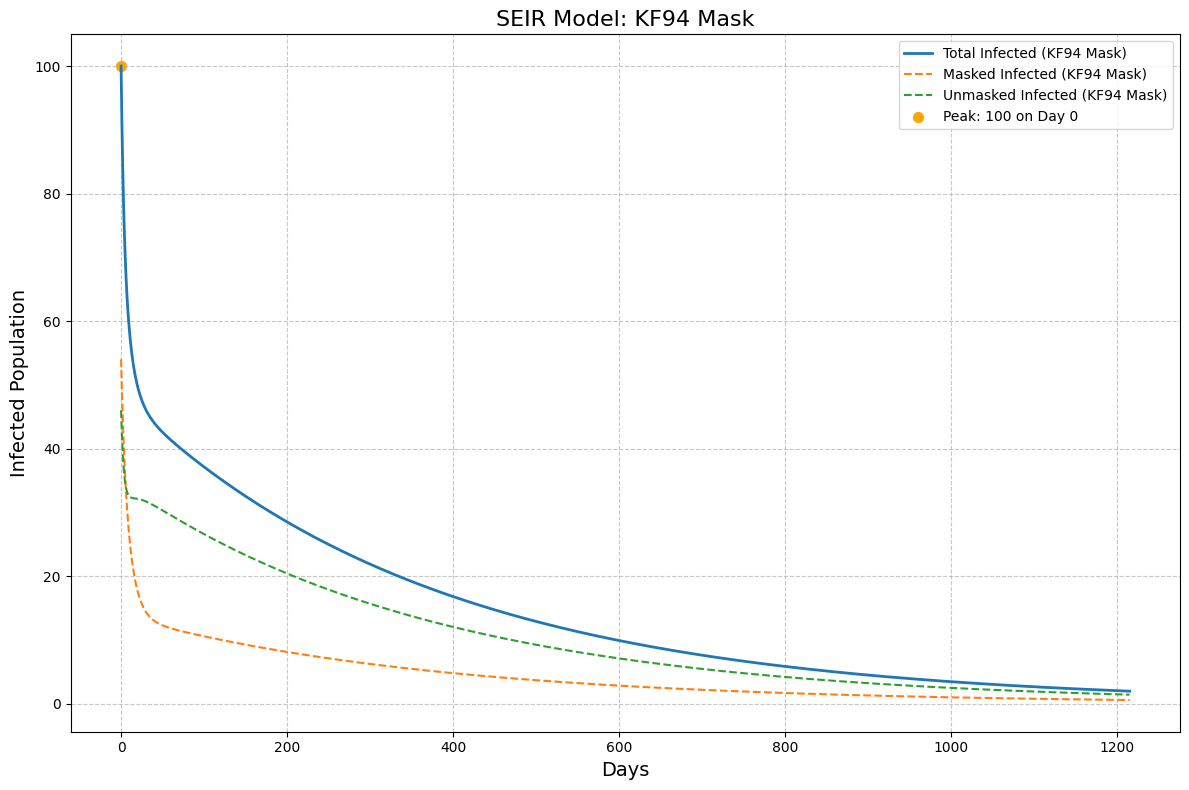

In [ ]:
#마스크 미착용자 30%
#초기감염자 100명
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# SEIR 모델 방정식
def seir_model(y, t, N, beta, sigma, gamma, eta_s, eta_i, mask_wearing_ratio):
    S_masked, S_unmasked, E_masked, E_unmasked, I_masked, I_unmasked, R = y

    # 각 전염 경로에 따른 beta 조정
    beta_masked_to_unmasked = beta * (1 - eta_i)  # 마스크 쓴 사람이 마스크 안 쓴 감염자를 감염시킬 때
    beta_masked_to_masked = beta * (1 - eta_i) * (1 - eta_s)    # 마스크 쓴 사람이 마스크 쓴 감염자를 감염시킬 때
    beta_unmasked_to_unmasked = beta # 마스크 안 쓴 사람이 마스크 안 쓴 감염자와 접촉할 때
    beta_unmasked_to_masked = beta * (1 - eta_s)   # 마스크 안 쓴 사람이 마스크 쓴 감염자와 접촉할 때

    # S -> E (마스크 착용 여부에 따른 전염 경로)
    dS_masked_dt = -(beta_masked_to_unmasked * S_masked * I_unmasked / N) - (beta_masked_to_masked * S_masked * I_masked / N)  # 마스크 쓴 S가 E로 전환되는 사람 수
    dS_unmasked_dt = -(beta_unmasked_to_masked * S_unmasked * I_masked / N) - (beta_unmasked_to_unmasked * S_unmasked * I_unmasked / N)  # 마스크 안쓴 S가 E로 전환되는 사람 수

    # E -> I (노출자가 감염자로 전환)
    dE_masked_dt = (beta_masked_to_unmasked * S_masked * I_unmasked / N) + (beta_masked_to_masked * S_masked * I_masked / N) - sigma * E_masked
    # +마스크 쓴 S가 E로 전환된 사람 수 - 마스크 쓴 E * 전환비율(시그마)
    dE_unmasked_dt = (beta_unmasked_to_masked * S_unmasked * I_masked / N) + (beta_unmasked_to_unmasked * S_unmasked * I_unmasked / N) - sigma * E_unmasked
    # +마스크 안 쓴 S가 E로 전환된 사람 수 - 마스크 쓴 E * 전환비율(시그마)

    # I -> R (감염자가 회복자로 전환)
    dI_masked_dt = sigma * E_masked - gamma * I_masked # E->I로 전환된 사람 수 (마스크 쓴 사람) - 마스크 쓴 I * 전환비율(감마)
    dI_unmasked_dt = sigma * E_unmasked - gamma * I_unmasked #E->I로 전환된 사람 수 (마스크 안 쓴 사람) - 마스크 쓴 I * 전환비율(감마)

    # 회복된 사람들
    dR_dt = gamma * (I_masked + I_unmasked) # E-R 전환된 사람 수

    return dS_masked_dt, dS_unmasked_dt, dE_masked_dt, dE_unmasked_dt, dI_masked_dt, dI_unmasked_dt, dR_dt

# 초기 조건 및 파라미터 설정  #초기 감염자 : 1,000명
N = 50_000_000   # 총 인구 수 (5천만)
I_masked0 = 54  # 초기 감염자 중 마스크 착용
I_unmasked0 = 46  # 초기 감염자 중 마스크 미착용
I0 = I_masked0 + I_unmasked0  # 초기 총 감염자
E0, R0 = 0, 0  # 초기 노출자, 회복자
mask_wearing_ratio = 0.70  # 마스크 착용 비율
S0 = N - I0 - E0 - R0  # 초기 감염 가능자
#S_unmasked0 = S0 * mask_wearing_ratio  # 마스크를 쓰지 않은 감염 가능자
S_unmasked0 = S0 - S_masked0  # 마스크를 쓰지 않은 감염 가능자
S_masked0 = S0 * mask_wearing_ratio  # 마스크를 쓴 감염 가능자
E_masked0 = 0  # 초기 마스크 착용자 노출자
E_unmasked0 = 0  # 초기 마스크 미착용자 노출자
y0 = [S_masked0, S_unmasked0, E_masked0, E_unmasked0, I_masked0, I_unmasked0, R0]

beta = 0.3            # 감염률
sigma = 1 / 5         # 노출 상태에서 감염으로 전환 비율 (잠복기 5일)
gamma = 1 / 10        # 감염 상태에서 회복으로 전환 비율 (회복 기간 10일)
days = 1215          # 시뮬레이션 기간 (3년 4개월 = 1215일)==========
t = np.linspace(0, days, days)

# KF94 마스크에 대한
#eta_s : 감염 가능자(S)가 마스크 쓸 때 감염 감소율
#eta_I : 감염자(I)가 마스크 쓸 때 전파 감소율
eta_s, eta_i = 0.83, 0.83  # KF94 마스크 필터 효율

# SEIR 모델 시뮬레이션
result = odeint(seir_model, y0, t, args=(N, beta, sigma, gamma, eta_s, eta_i, mask_wearing_ratio))
S_masked, S_unmasked, E_masked, E_unmasked, I_masked, I_unmasked, R = result.T

# 전체 감염자 계산
I_total = I_masked + I_unmasked

# 피크 값과 피크 시점 계산
peak_infected = np.max(I_total)
peak_day = t[np.argmax(I_total)]

# 결과 출력
print(f"KF94 Mask: Peak Infected: {int(peak_infected):,}, Peak Day: {int(peak_day)} days")

# 그래프 생성
plt.figure(figsize=(12, 8))
plt.plot(t, I_total, label=f'Total Infected (KF94 Mask)', linewidth=2)
plt.plot(t, I_masked, label=f'Masked Infected (KF94 Mask)', linestyle='--')
plt.plot(t, I_unmasked, label=f'Unmasked Infected (KF94 Mask)', linestyle='--')

# 피크 값 표시
plt.scatter(peak_day, peak_infected, color='orange', s=50, label=f'Peak: {int(peak_infected)} on Day {int(peak_day)}')

# 그래프 설정
plt.xlabel('Days', fontsize=14)
plt.ylabel('Infected Population', fontsize=14)
plt.title('SEIR Model: KF94 Mask', fontsize=16)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
#임계점 찾기

import numpy as np
from scipy.integrate import odeint

# SEIR 모델 방정식
def seir_model(y, t, N, beta, sigma, gamma, eta_s, eta_i, mask_wearing_ratio):
    S_masked, S_unmasked, E_masked, E_unmasked, I_masked, I_unmasked, R = y

    # 각 전염 경로에 따른 beta 조정
    beta_masked_to_unmasked = beta * (1 - eta_i)
    beta_masked_to_masked = beta * (1 - eta_i) * (1 - eta_s)
    beta_unmasked_to_unmasked = beta
    beta_unmasked_to_masked = beta * (1 - eta_s)

    # S -> E
    dS_masked_dt = -(beta_masked_to_unmasked * S_masked * I_unmasked / N) - (beta_masked_to_masked * S_masked * I_masked / N)
    dS_unmasked_dt = -(beta_unmasked_to_masked * S_unmasked * I_masked / N) - (beta_unmasked_to_unmasked * S_unmasked * I_unmasked / N)

    # E -> I
    dE_masked_dt = (beta_masked_to_unmasked * S_masked * I_unmasked / N) + (beta_masked_to_masked * S_masked * I_masked / N) - sigma * E_masked
    dE_unmasked_dt = (beta_unmasked_to_masked * S_unmasked * I_masked / N) + (beta_unmasked_to_unmasked * S_unmasked * I_unmasked / N) - sigma * E_unmasked

    # I -> R
    dI_masked_dt = sigma * E_masked - gamma * I_masked
    dI_unmasked_dt = sigma * E_unmasked - gamma * I_unmasked

    # 회복자
    dR_dt = gamma * (I_masked + I_unmasked)

    return dS_masked_dt, dS_unmasked_dt, dE_masked_dt, dE_unmasked_dt, dI_masked_dt, dI_unmasked_dt, dR_dt

# 초기 조건 및 파라미터 설정
N = 50_000_000
I_masked0 = 54
I_unmasked0 = 46
I0 = I_masked0 + I_unmasked0
E0, R0 = 0, 0
beta = 0.3
sigma = 1 / 5
gamma = 1 / 10
days = 1215
t = np.linspace(0, days, days)
eta_s, eta_i = 0.83, 0.83

# 마스크 착용 비율 테스트
mask_ratios = np.linspace(0.95, 0.50, 20)  # 95% ~ 500단계
previous_curve = None
threshold_ratio = None
tolerance = 1e4  # 곡선 변화 감지 임계값 (차이의 총합)

for mask_wearing_ratio in mask_ratios:
    S0 = N - I0 - E0 - R0
    S_masked0 = S0 * mask_wearing_ratio
    S_unmasked0 = S0 - S_masked0
    E_masked0, E_unmasked0 = 0, 0
    y0 = [S_masked0, S_unmasked0, E_masked0, E_unmasked0, I_masked0, I_unmasked0, R0]

    # SEIR 모델 시뮬레이션
    result = odeint(seir_model, y0, t, args=(N, beta, sigma, gamma, eta_s, eta_i, mask_wearing_ratio))
    S_masked, S_unmasked, E_masked, E_unmasked, I_masked, I_unmasked, R = result.T

    # 전체 감염자 계산
    I_total = I_masked + I_unmasked

    # 이전 곡선과 비교
    if previous_curve is not None:
        difference = np.sum(np.abs(I_total - previous_curve))  # 곡선 차이 계산
        if difference > tolerance:
            threshold_ratio = mask_wearing_ratio
            break  # 임계점 발견 시 종료

    previous_curve = I_total

# 결과 출력
if threshold_ratio:
    print(f"감염 곡선 모양이 급격히 달라지는 마스크 착용 비율: {threshold_ratio * 100:.1f}%")
    print(f"마스크 미착용자 비율: {100 - threshold_ratio * 100:.1f}%")


감염 곡선 모양이 급격히 달라지는 마스크 착용 비율: 68.9%
마스크 미착용자 비율: 31.1%


#초기 감염자 1,000명
##마스크 미착용자 30%
##마스크 미착용자 20%
그래프 모양 달라짐 → 임계점 : 26.3%


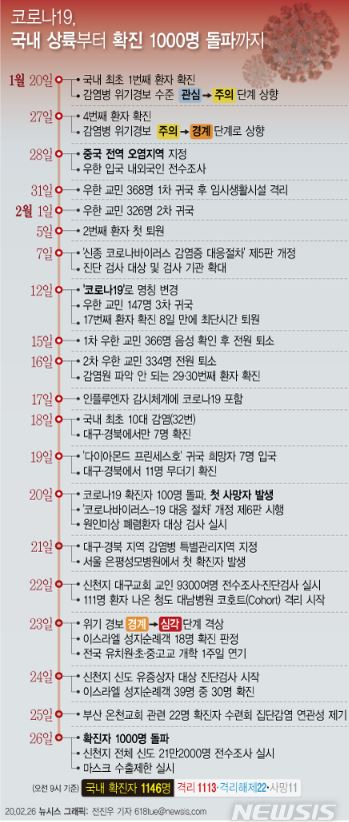

KF94 Mask: Peak Infected: 4,538,969, Peak Day: 177 days


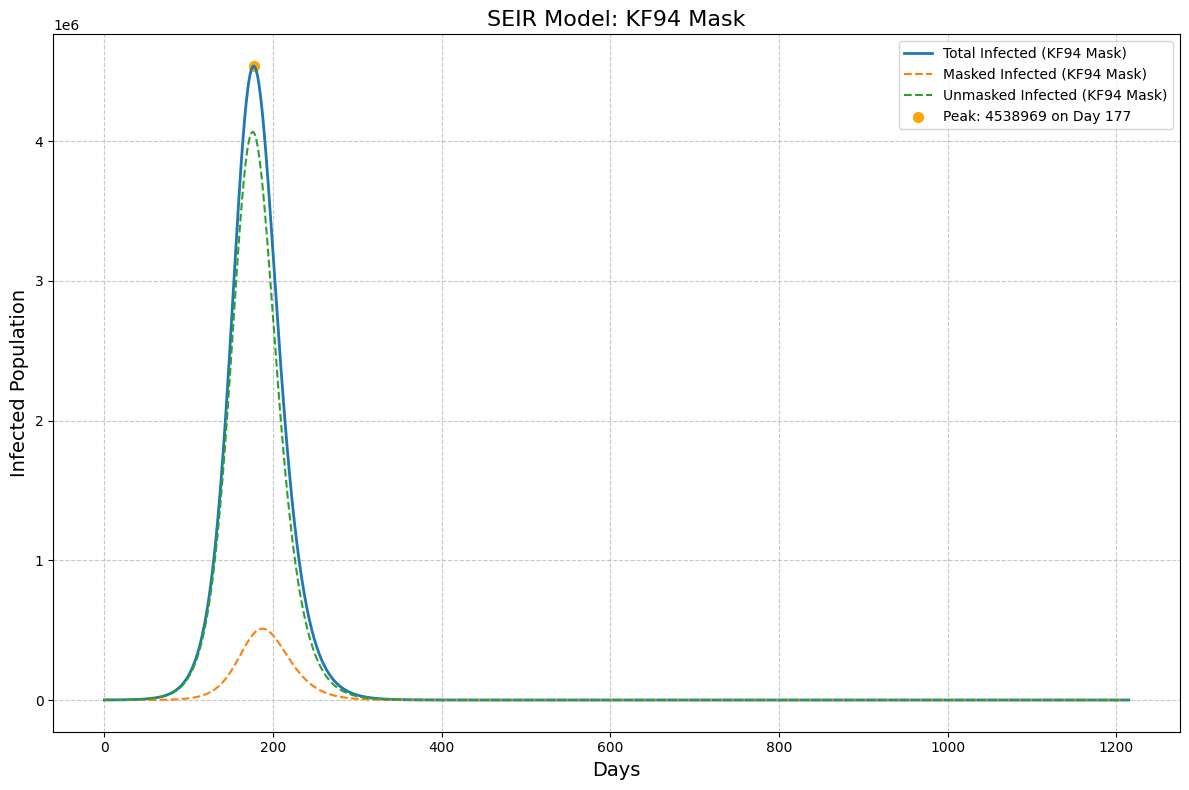

In [ ]:
#마스크 미착용자 30%
#초기 감염자 1,000명

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# SEIR 모델 방정식
def seir_model(y, t, N, beta, sigma, gamma, eta_s, eta_i, mask_wearing_ratio):
    S_masked, S_unmasked, E_masked, E_unmasked, I_masked, I_unmasked, R = y

    # 각 전염 경로에 따른 beta 조정
    beta_masked_to_unmasked = beta * (1 - eta_i)  # 마스크 쓴 사람이 마스크 안 쓴 감염자를 감염시킬 때
    beta_masked_to_masked = beta * (1 - eta_i) * (1 - eta_s)    # 마스크 쓴 사람이 마스크 쓴 감염자를 감염시킬 때
    beta_unmasked_to_unmasked = beta # 마스크 안 쓴 사람이 마스크 안 쓴 감염자와 접촉할 때
    beta_unmasked_to_masked = beta * (1 - eta_s)   # 마스크 안 쓴 사람이 마스크 쓴 감염자와 접촉할 때

    # S -> E (마스크 착용 여부에 따른 전염 경로)
    dS_masked_dt = -(beta_masked_to_unmasked * S_masked * I_unmasked / N) - (beta_masked_to_masked * S_masked * I_masked / N)  # 마스크 쓴 S가 E로 전환되는 사람 수
    dS_unmasked_dt = -(beta_unmasked_to_masked * S_unmasked * I_masked / N) - (beta_unmasked_to_unmasked * S_unmasked * I_unmasked / N)  # 마스크 안쓴 S가 E로 전환되는 사람 수

    # E -> I (노출자가 감염자로 전환)
    dE_masked_dt = (beta_masked_to_unmasked * S_masked * I_unmasked / N) + (beta_masked_to_masked * S_masked * I_masked / N) - sigma * E_masked
    # +마스크 쓴 S가 E로 전환된 사람 수 - 마스크 쓴 E * 전환비율(시그마)
    dE_unmasked_dt = (beta_unmasked_to_masked * S_unmasked * I_masked / N) + (beta_unmasked_to_unmasked * S_unmasked * I_unmasked / N) - sigma * E_unmasked
    # +마스크 안 쓴 S가 E로 전환된 사람 수 - 마스크 쓴 E * 전환비율(시그마)

    # I -> R (감염자가 회복자로 전환)
    dI_masked_dt = sigma * E_masked - gamma * I_masked # E->I로 전환된 사람 수 (마스크 쓴 사람) - 마스크 쓴 I * 전환비율(감마)
    dI_unmasked_dt = sigma * E_unmasked - gamma * I_unmasked #E->I로 전환된 사람 수 (마스크 안 쓴 사람) - 마스크 쓴 I * 전환비율(감마)

    # 회복된 사람들
    dR_dt = gamma * (I_masked + I_unmasked) # E-R 전환된 사람 수

    return dS_masked_dt, dS_unmasked_dt, dE_masked_dt, dE_unmasked_dt, dI_masked_dt, dI_unmasked_dt, dR_dt

# 초기 조건 및 파라미터 설정  #초기 감염자 : 1,000명
N = 50_000_000   # 총 인구 수 (5천만)
I_masked0 = 540  # 초기 감염자 중 마스크 착용
I_unmasked0 = 460  # 초기 감염자 중 마스크 미착용
I0 = I_masked0 + I_unmasked0  # 초기 총 감염자
E0, R0 = 0, 0  # 초기 노출자, 회복자
mask_wearing_ratio = 0.30  # 마스크 착용 비율
S0 = N - I0 - E0 - R0  # 초기 감염 가능자
S_masked0 = S0 * mask_wearing_ratio  # 마스크를 쓴 감염 가능자
S_unmasked0 = S0 - S_masked0  # 마스크를 쓰지 않은 감염 가능자
E_masked0 = 0  # 초기 마스크 착용자 노출자
E_unmasked0 = 0  # 초기 마스크 미착용자 노출자
y0 = [S_masked0, S_unmasked0, E_masked0, E_unmasked0, I_masked0, I_unmasked0, R0]

beta = 0.3            # 감염률
sigma = 1 / 5         # 노출 상태에서 감염으로 전환 비율 (잠복기 5일)
gamma = 1 / 10        # 감염 상태에서 회복으로 전환 비율 (회복 기간 10일)
days = 1215          # 시뮬레이션 기간 (3년 4개월 = 1215일)==========
t = np.linspace(0, days, days)

# KF94 마스크에 대한
#eta_s : 감염 가능자(S)가 마스크 쓸 때 감염 감소율
#eta_I : 감염자(I)가 마스크 쓸 때 전파 감소율
eta_s, eta_i = 0.83, 0.83  # KF94 마스크 필터 효율

# SEIR 모델 시뮬레이션
result = odeint(seir_model, y0, t, args=(N, beta, sigma, gamma, eta_s, eta_i, mask_wearing_ratio))
S_masked, S_unmasked, E_masked, E_unmasked, I_masked, I_unmasked, R = result.T

# 전체 감염자 계산
I_total = I_masked + I_unmasked

# 피크 값과 피크 시점 계산
peak_infected = np.max(I_total)
peak_day = t[np.argmax(I_total)]

# 결과 출력
print(f"KF94 Mask: Peak Infected: {int(peak_infected):,}, Peak Day: {int(peak_day)} days")

# 그래프 생성
plt.figure(figsize=(12, 8))
plt.plot(t, I_total, label=f'Total Infected (KF94 Mask)', linewidth=2)
plt.plot(t, I_masked, label=f'Masked Infected (KF94 Mask)', linestyle='--')
plt.plot(t, I_unmasked, label=f'Unmasked Infected (KF94 Mask)', linestyle='--')

# 피크 값 표시
plt.scatter(peak_day, peak_infected, color='orange', s=50, label=f'Peak: {int(peak_infected)} on Day {int(peak_day)}')

# 그래프 설정
plt.xlabel('Days', fontsize=14)
plt.ylabel('Infected Population', fontsize=14)
plt.title('SEIR Model: KF94 Mask', fontsize=16)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

KF94 Mask: Peak Infected: 1,000, Peak Day: 0 days


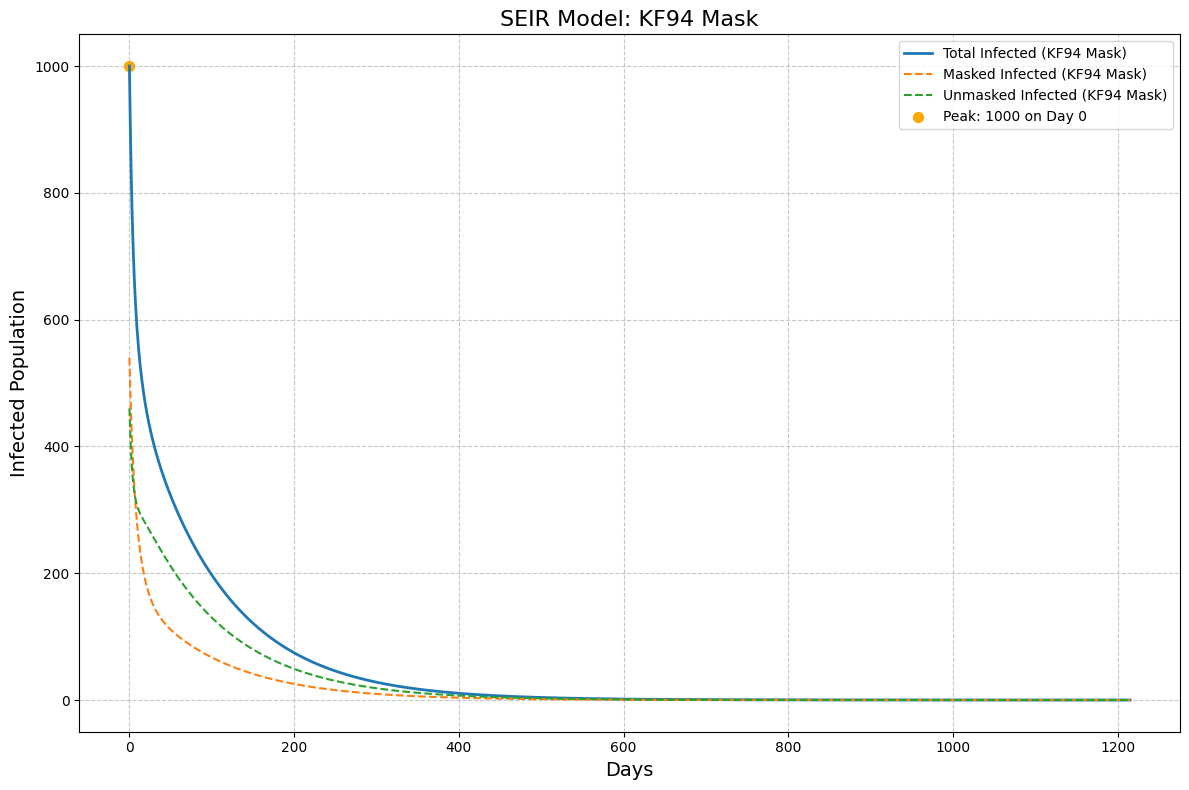

In [ ]:
#마스크 미착용자 20%

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# SEIR 모델 방정식
def seir_model(y, t, N, beta, sigma, gamma, eta_s, eta_i, mask_wearing_ratio):
    S_masked, S_unmasked, E_masked, E_unmasked, I_masked, I_unmasked, R = y

    # 각 전염 경로에 따른 beta 조정
    beta_masked_to_unmasked = beta * (1 - eta_i)  # 마스크 쓴 사람이 마스크 안 쓴 감염자를 감염시킬 때
    beta_masked_to_masked = beta * (1 - eta_i) * (1 - eta_s)    # 마스크 쓴 사람이 마스크 쓴 감염자를 감염시킬 때
    beta_unmasked_to_unmasked = beta # 마스크 안 쓴 사람이 마스크 안 쓴 감염자와 접촉할 때
    beta_unmasked_to_masked = beta * (1 - eta_s)   # 마스크 안 쓴 사람이 마스크 쓴 감염자와 접촉할 때

    # S -> E (마스크 착용 여부에 따른 전염 경로)
    dS_masked_dt = -(beta_masked_to_unmasked * S_masked * I_unmasked / N) - (beta_masked_to_masked * S_masked * I_masked / N)  # 마스크 쓴 S가 E로 전환되는 사람 수
    dS_unmasked_dt = -(beta_unmasked_to_masked * S_unmasked * I_masked / N) - (beta_unmasked_to_unmasked * S_unmasked * I_unmasked / N)  # 마스크 안쓴 S가 E로 전환되는 사람 수

    # E -> I (노출자가 감염자로 전환)
    dE_masked_dt = (beta_masked_to_unmasked * S_masked * I_unmasked / N) + (beta_masked_to_masked * S_masked * I_masked / N) - sigma * E_masked
    # +마스크 쓴 S가 E로 전환된 사람 수 - 마스크 쓴 E * 전환비율(시그마)
    dE_unmasked_dt = (beta_unmasked_to_masked * S_unmasked * I_masked / N) + (beta_unmasked_to_unmasked * S_unmasked * I_unmasked / N) - sigma * E_unmasked
    # +마스크 안 쓴 S가 E로 전환된 사람 수 - 마스크 쓴 E * 전환비율(시그마)

    # I -> R (감염자가 회복자로 전환)
    dI_masked_dt = sigma * E_masked - gamma * I_masked # E->I로 전환된 사람 수 (마스크 쓴 사람) - 마스크 쓴 I * 전환비율(감마)
    dI_unmasked_dt = sigma * E_unmasked - gamma * I_unmasked #E->I로 전환된 사람 수 (마스크 안 쓴 사람) - 마스크 쓴 I * 전환비율(감마)

    # 회복된 사람들
    dR_dt = gamma * (I_masked + I_unmasked) # E-R 전환된 사람 수

    return dS_masked_dt, dS_unmasked_dt, dE_masked_dt, dE_unmasked_dt, dI_masked_dt, dI_unmasked_dt, dR_dt

# 초기 조건 및 파라미터 설정  #초기 감염자 : 1,000명
N = 50_000_000   # 총 인구 수 (5천만)
I_masked0 = 540  # 초기 감염자 중 마스크 착용
I_unmasked0 = 460  # 초기 감염자 중 마스크 미착용
I0 = I_masked0 + I_unmasked0  # 초기 총 감염자
E0, R0 = 0, 0  # 초기 노출자, 회복자
mask_wearing_ratio = 0.80  # 마스크 착용 비율
S0 = N - I0 - E0 - R0  # 초기 감염 가능자
S_unmasked0 = S0 - S_masked0  # 마스크를 쓰지 않은 감염 가능자
S_masked0 = S0 * mask_wearing_ratio  # 마스크를 쓴 감염 가능자
E_masked0 = 0  # 초기 마스크 착용자 노출자
E_unmasked0 = 0  # 초기 마스크 미착용자 노출자
y0 = [S_masked0, S_unmasked0, E_masked0, E_unmasked0, I_masked0, I_unmasked0, R0]

beta = 0.3            # 감염률
sigma = 1 / 5         # 노출 상태에서 감염으로 전환 비율 (잠복기 5일)
gamma = 1 / 10        # 감염 상태에서 회복으로 전환 비율 (회복 기간 10일)
days = 1215           # 시뮬레이션 기간 (3년 4개월 = 1215일)==========
t = np.linspace(0, days, days)

# KF94 마스크에 대한
#eta_s : 감염 가능자(S)가 마스크 쓸 때 감염 감소율
#eta_I : 감염자(I)가 마스크 쓸 때 전파 감소율
eta_s, eta_i = 0.83, 0.83  # KF94 마스크 필터 효율

# SEIR 모델 시뮬레이션
result = odeint(seir_model, y0, t, args=(N, beta, sigma, gamma, eta_s, eta_i, mask_wearing_ratio))
S_masked, S_unmasked, E_masked, E_unmasked, I_masked, I_unmasked, R = result.T

# 전체 감염자 계산
I_total = I_masked + I_unmasked

# 피크 값과 피크 시점 계산
peak_infected = np.max(I_total)
peak_day = t[np.argmax(I_total)]

# 결과 출력
print(f"KF94 Mask: Peak Infected: {int(peak_infected):,}, Peak Day: {int(peak_day)} days")

# 그래프 생성
plt.figure(figsize=(12, 8))
plt.plot(t, I_total, label=f'Total Infected (KF94 Mask)', linewidth=2)
plt.plot(t, I_masked, label=f'Masked Infected (KF94 Mask)', linestyle='--')
plt.plot(t, I_unmasked, label=f'Unmasked Infected (KF94 Mask)', linestyle='--')

# 피크 값 표시
plt.scatter(peak_day, peak_infected, color='orange', s=50, label=f'Peak: {int(peak_infected)} on Day {int(peak_day)}')

# 그래프 설정
plt.xlabel('Days', fontsize=14)
plt.ylabel('Infected Population', fontsize=14)
plt.title('SEIR Model: KF94 Mask', fontsize=16)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
#임계점 찾기

import numpy as np
from scipy.integrate import odeint

# SEIR 모델 방정식
def seir_model(y, t, N, beta, sigma, gamma, eta_s, eta_i, mask_wearing_ratio):
    S_masked, S_unmasked, E_masked, E_unmasked, I_masked, I_unmasked, R = y

    # 각 전염 경로에 따른 beta 조정
    beta_masked_to_unmasked = beta * (1 - eta_i)
    beta_masked_to_masked = beta * (1 - eta_i) * (1 - eta_s)
    beta_unmasked_to_unmasked = beta
    beta_unmasked_to_masked = beta * (1 - eta_s)

    # S -> E
    dS_masked_dt = -(beta_masked_to_unmasked * S_masked * I_unmasked / N) - (beta_masked_to_masked * S_masked * I_masked / N)
    dS_unmasked_dt = -(beta_unmasked_to_masked * S_unmasked * I_masked / N) - (beta_unmasked_to_unmasked * S_unmasked * I_unmasked / N)

    # E -> I
    dE_masked_dt = (beta_masked_to_unmasked * S_masked * I_unmasked / N) + (beta_masked_to_masked * S_masked * I_masked / N) - sigma * E_masked
    dE_unmasked_dt = (beta_unmasked_to_masked * S_unmasked * I_masked / N) + (beta_unmasked_to_unmasked * S_unmasked * I_unmasked / N) - sigma * E_unmasked

    # I -> R
    dI_masked_dt = sigma * E_masked - gamma * I_masked
    dI_unmasked_dt = sigma * E_unmasked - gamma * I_unmasked

    # 회복자
    dR_dt = gamma * (I_masked + I_unmasked)

    return dS_masked_dt, dS_unmasked_dt, dE_masked_dt, dE_unmasked_dt, dI_masked_dt, dI_unmasked_dt, dR_dt

# 초기 조건 및 파라미터 설정
N = 50_000_000
I_masked0 = 540
I_unmasked0 = 460
I0 = I_masked0 + I_unmasked0
E0, R0 = 0, 0
beta = 0.3
sigma = 1 / 5
gamma = 1 / 10
days = 1215
t = np.linspace(0, days, days)
eta_s, eta_i = 0.83, 0.83

# 마스크 착용 비율 테스트
mask_ratios = np.linspace(0.95, 0.50, 20)  # 95% ~ 50%까지 20단계
previous_curve = None
threshold_ratio = None
tolerance = 1e4  # 곡선 변화 감지 임계값 (차이의 총합)

for mask_wearing_ratio in mask_ratios:
    S0 = N - I0 - E0 - R0
    S_masked0 = S0 * mask_wearing_ratio
    S_unmasked0 = S0 - S_masked0
    E_masked0, E_unmasked0 = 0, 0
    y0 = [S_masked0, S_unmasked0, E_masked0, E_unmasked0, I_masked0, I_unmasked0, R0]

    # SEIR 모델 시뮬레이션
    result = odeint(seir_model, y0, t, args=(N, beta, sigma, gamma, eta_s, eta_i, mask_wearing_ratio))
    S_masked, S_unmasked, E_masked, E_unmasked, I_masked, I_unmasked, R = result.T

    # 전체 감염자 계산
    I_total = I_masked + I_unmasked

    # 이전 곡선과 비교
    if previous_curve is not None:
        difference = np.sum(np.abs(I_total - previous_curve))  # 곡선 차이 계산
        if difference > tolerance:
            threshold_ratio = mask_wearing_ratio
            break  # 임계점 발견 시 종료

    previous_curve = I_total

# 결과 출력
if threshold_ratio:
    print(f"감염 곡선 모양이 급격히 달라지는 마스크 착용 비율: {threshold_ratio * 100:.1f}%")
    print(f"마스크 미착용자 비율: {100 - threshold_ratio * 100:.1f}%")


감염 곡선 모양이 급격히 달라지는 마스크 착용 비율: 73.7%
마스크 미착용자 비율: 26.3%


#일일 확진자 수에 대한 임계점 찾기

자료 : 질병관리청



In [ ]:
import pandas as pd
import numpy as np
from scipy.integrate import odeint

# SEIR 모델 방정식 정의
def seir_model(y, t, N, beta, sigma, gamma, eta_s, eta_i, mask_wearing_ratio):
    S_masked, S_unmasked, E_masked, E_unmasked, I_masked, I_unmasked, R = y

    # 각 전염 경로에 따른 beta 조정
    beta_masked_to_unmasked = beta * (1 - eta_i)
    beta_masked_to_masked = beta * (1 - eta_i) * (1 - eta_s)
    beta_unmasked_to_unmasked = beta
    beta_unmasked_to_masked = beta * (1 - eta_s)

    # S -> E
    dS_masked_dt = -(beta_masked_to_unmasked * S_masked * I_unmasked / N) - (beta_masked_to_masked * S_masked * I_masked / N)
    dS_unmasked_dt = -(beta_unmasked_to_masked * S_unmasked * I_masked / N) - (beta_unmasked_to_unmasked * S_unmasked * I_unmasked / N)

    # E -> I
    dE_masked_dt = (beta_masked_to_unmasked * S_masked * I_unmasked / N) + (beta_masked_to_masked * S_masked * I_masked / N) - sigma * E_masked
    dE_unmasked_dt = (beta_unmasked_to_masked * S_unmasked * I_masked / N) + (beta_unmasked_to_unmasked * S_unmasked * I_unmasked / N) - sigma * E_unmasked

    # I -> R
    dI_masked_dt = sigma * E_masked - gamma * I_masked
    dI_unmasked_dt = sigma * E_unmasked - gamma * I_unmasked

    # 회복자
    dR_dt = gamma * (I_masked + I_unmasked)

    return dS_masked_dt, dS_unmasked_dt, dE_masked_dt, dE_unmasked_dt, dI_masked_dt, dI_unmasked_dt, dR_dt


# SEIR 모델을 통한 마스크 미착용 비율 임계점 도출
def find_threshold(df_daily_cases, N, beta, sigma, gamma, eta_s, eta_i):
    # 마스크 착용 비율 테스트 범위
    mask_ratios = np.linspace(0.95, 0.50, 20)  # 95% ~ 50%까지 20단계
    tolerance = 1e4  # 곡선 변화 감지 임계값

    results = []

    for index, row in df_daily_cases.iterrows():
        if pd.isnull(row['계(명)']) or row['계(명)'] == '-':
            continue

        current_infected = int(row['계(명)'])
        if current_infected < 1:
            continue

        S0 = N - current_infected
        E0, R0 = 0, 0
        I_masked0, I_unmasked0 = current_infected * 0.54, current_infected * 0.46

        threshold_ratio = None
        previous_curve = None

        for mask_wearing_ratio in mask_ratios:
            S_masked0 = S0 * mask_wearing_ratio
            S_unmasked0 = S0 - S_masked0
            E_masked0, E_unmasked0 = 0, 0
            y0 = [S_masked0, S_unmasked0, E_masked0, E_unmasked0, I_masked0, I_unmasked0, R0]

            # SEIR 모델 시뮬레이션
            t = np.linspace(0, 365, 365)  # 1년 동안 시뮬레이션
            result = odeint(seir_model, y0, t, args=(N, beta, sigma, gamma, eta_s, eta_i, mask_wearing_ratio))
            S_masked, S_unmasked, E_masked, E_unmasked, I_masked, I_unmasked, R = result.T
            I_total = I_masked + I_unmasked  # 전체 감염자 수

            # 이전 곡선과 비교
            if previous_curve is not None:
                difference = np.sum(np.abs(I_total - previous_curve))  # 곡선 차이 계산
                if difference > tolerance:
                    threshold_ratio = mask_wearing_ratio
                    break  # 임계점 발견 시 종료

            previous_curve = I_total

        if threshold_ratio:
            results.append({
                "날짜": row["일자"],
                "확진자 수": current_infected,
                "마스크 착용 비율 (%)": round(threshold_ratio * 100, 1),
                "미착용 비율 (%)": round(100 - threshold_ratio * 100, 1)
            })

    return pd.DataFrame(results)


# 파일 경로 및 데이터 읽기
file_path = '/content/infected_people_per_day.xlsx'
df_cleaned = pd.read_excel(file_path, sheet_name="발생별(국내발생+해외유입), 사망", header=4)

# 데이터 정리
df_daily_cases = df_cleaned[["일자", "계(명)"]]
df_daily_cases = df_daily_cases.dropna(subset=["일자", "계(명)"])  # 유효한 데이터만 남기기
df_daily_cases = df_daily_cases[df_daily_cases["계(명)"] != "-"]  # "-" 제거
df_daily_cases["계(명)"] = pd.to_numeric(df_daily_cases["계(명)"], errors='coerce')  # 숫자로 변환

# 모델 초기값 및 파라미터 설정
N = 50_000_000  # 총 인구
beta = 0.3
sigma = 1 / 5  # 평균 잠복기 5일
gamma = 1 / 10  # 평균 회복 기간 10일
eta_s, eta_i = 0.83, 0.83  # 마스크 효과

# 임계점 분석 실행
threshold_results = find_threshold(df_daily_cases, N, beta, sigma, gamma, eta_s, eta_i)

# 결과 출력

# 처음 60행 출력
print(threshold_results.head(60))

# 마지막 50행 출력
print(threshold_results.tail(50))



FileNotFoundError: [Errno 2] No such file or directory: '/content/infected_people_per_day.xlsx'